In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pySAMetrics
import matplotlib.pyplot as plt
from pySAMetrics.Simulation import Simulation
from pySAMetrics.utils import generate_simulation_paths
from tqdm import tqdm

In [2]:
import h5py

# Load the data from the HDF5 file
with h5py.File('reshaped_data_all_domain.h5', 'r') as f:
    reshaped_data_all_domain = f['data'][:]

In [3]:
import pickle

with open('kmeans_model_all_domain.pkl', 'rb') as f:
    kmeans_all_domain = pickle.load(f)

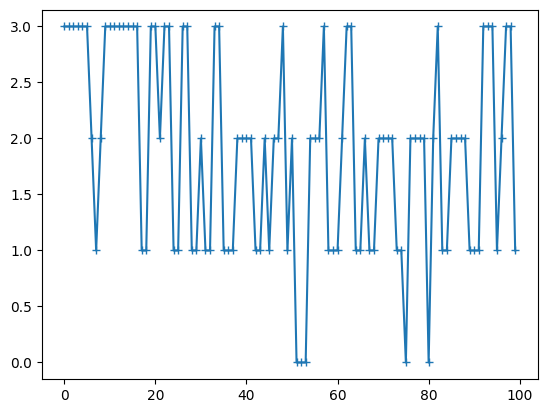

In [4]:
plt.plot(kmeans_all_domain.labels_[:100], '+-')

In [5]:
from scipy.spatial.distance import cdist

vectors = np.array([kmeans_all_domain.cluster_centers_[0], kmeans_all_domain.cluster_centers_[1], kmeans_all_domain.cluster_centers_[2]])

# Compute the pairwise Euclidean distance matrix
dist_matrix = cdist(vectors, vectors, metric='euclidean')

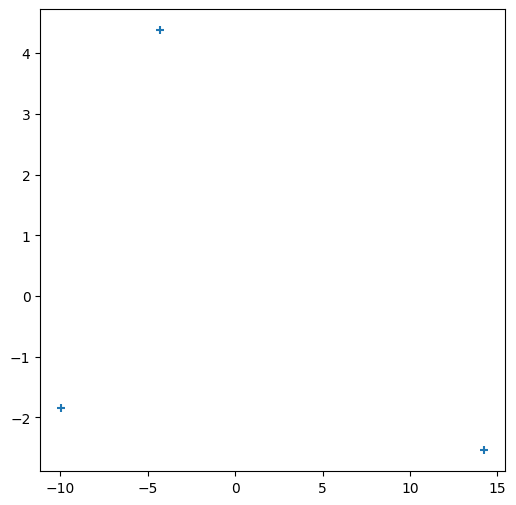

In [6]:
from sklearn.manifold import MDS

# Example: pairwise distances between three points
distances = dist_matrix

# Apply Multidimensional Scaling (MDS) to place the points in 2D
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
points_2d = mds.fit_transform(distances)

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], marker='+')


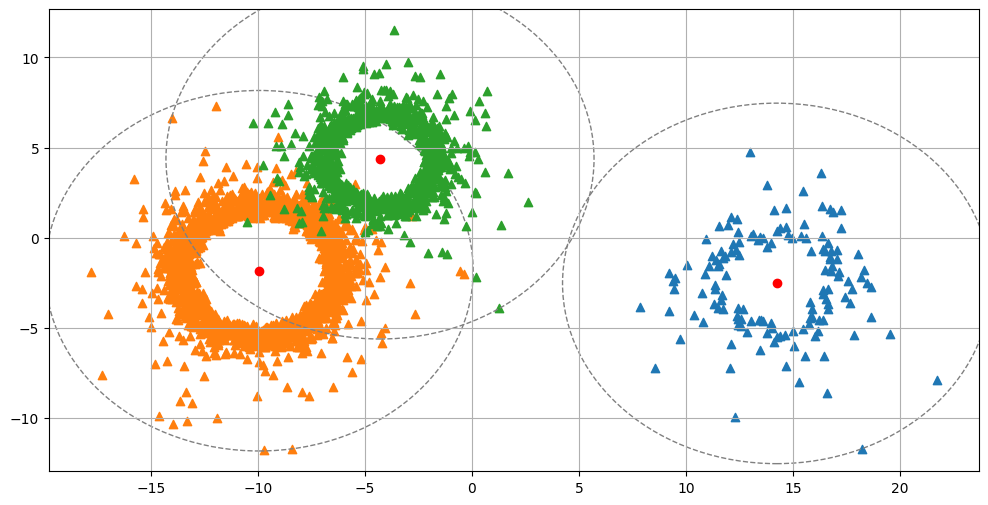

In [7]:
plt.figure(figsize=(12, 6))

for cluster_id in [0,1,2]:
    center = kmeans_all_domain.cluster_centers_[cluster_id]  # Get the center of the current cluster
    vectors = reshaped_data_all_domain[kmeans_all_domain.labels_ == cluster_id]  # Get vectors for current cluster
    
    # Compute distances from the vectors to the center
    distances_to_center = np.linalg.norm(vectors - center, axis=1)

    # Calculate the proportional radius for the circle placement
    max_distance = np.max(distances_to_center)
    circle_radius = 10  # The desired radius of the circle

    # Rescale the distances to fit the circle's radius
    proportional_radii = (distances_to_center / max_distance) * circle_radius

    # Calculate the angles (evenly spaced around the circle)
    angles = np.linspace(0, 2 * np.pi, len(vectors), endpoint=False)

    # Place the vectors around the circle based on the proportional distances and angles
    circle_positions = np.array([points_2d[cluster_id, 0] + proportional_radii * np.cos(angles), 
                                 points_2d[cluster_id, 1] + proportional_radii * np.sin(angles)]).T

    # Plot the central point (cluster center)
    plt.scatter(points_2d[cluster_id, 0], points_2d[cluster_id, 1], color='red', label=f'Center (Cluster {cluster_id})', zorder=5)

    # Plot the vectors around the center
    plt.scatter(circle_positions[:, 0], circle_positions[:, 1], marker='^', label=f'Cluster {cluster_id} Vectors')

    # Draw the circle (for visualization)
    circle = plt.Circle((points_2d[cluster_id, 0], points_2d[cluster_id, 1]), circle_radius, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
    plt.grid(True)

In [8]:
import pandas as pd

# Create an empty list to hold the data for the DataFrame
data_list = []

# Iterate through each cluster
for cluster_id in [0,1,2]:#np.unique(kmeans_all_domain.labels_):
    # Get the center of the current cluster
    center = kmeans_all_domain.cluster_centers_[cluster_id]

    # Get the indices of vectors associated with the current cluster
    cluster_indices = np.where(kmeans_all_domain.labels_ == cluster_id)[0]
    
    # Extract the corresponding vectors
    vectors = reshaped_data_all_domain[cluster_indices]

    # Calculate distances of vectors to the cluster center
    distances_to_center = np.linalg.norm(vectors - center, axis=1)

    # Calculate the proportional radius for circle placement
    max_distance = np.max(distances_to_center)
    circle_radius = 10  # Desired circle radius

    # Rescale the distances to fit the circle's radius
    proportional_radii = (distances_to_center / max_distance) * circle_radius

    # Calculate the angles for placement (evenly spaced)
    angles = np.linspace(0, 2 * np.pi, len(vectors), endpoint=False)

    # Place the vectors around the circle based on their distances and angles
    circle_positions = np.array([points_2d[cluster_id-1, 0] + proportional_radii * np.cos(angles),
                                 points_2d[cluster_id-1, 1] + proportional_radii * np.sin(angles)]).T

    # Append each vector's index, cluster label, and position to the list
    for i, idx in enumerate(cluster_indices):
        data_list.append([idx, cluster_id, circle_positions[i, 0], circle_positions[i, 1]])

# Create a DataFrame from the collected data
df_positions = pd.DataFrame(data_list, columns=['index', 'label', 'x', 'y'])



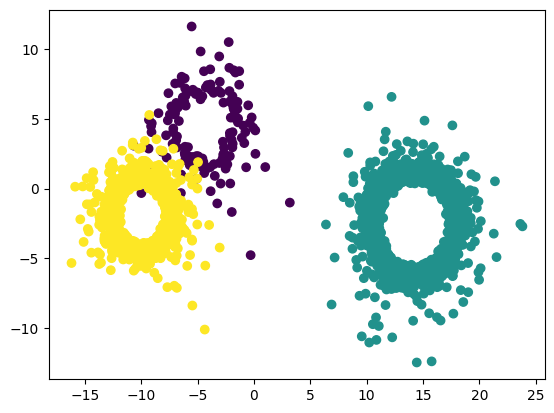

In [9]:
plt.scatter(df_positions['x'], df_positions['y'], c=df_positions['label'])



In [10]:
np.unique(df_positions['label'])

array([0, 1, 2])

In [11]:
df_positions = df_positions.sort_values(by='index')

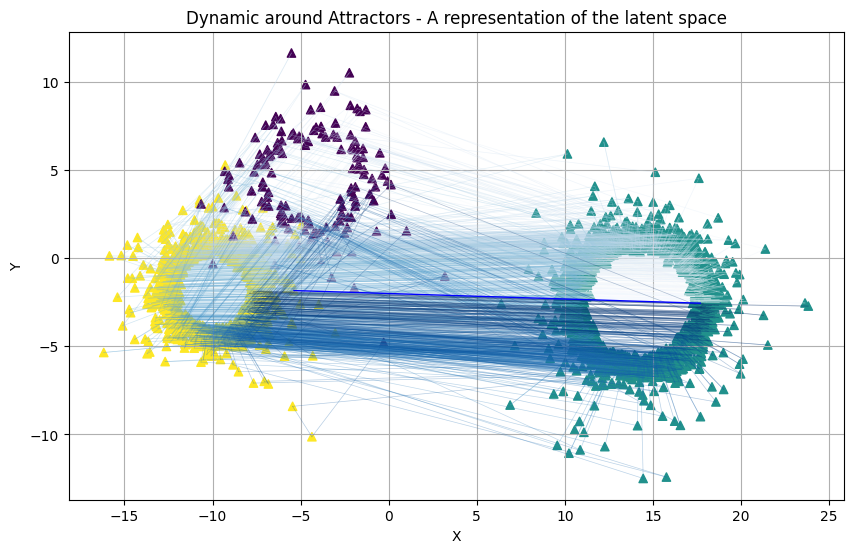

In [15]:
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('Blues')

# Normalize the color values based on the index range
norm = plt.Normalize(vmin=0, vmax=len(df_positions) - 1)
# Plot the points
plt.scatter(df_positions['x'], df_positions['y'], c=df_positions['label'], marker='^')#, label='Vectors')

# Draw lines connecting consecutive points based on the index
for i in range(len(df_positions) - 1):
    # Get x and y coordinates for consecutive points
    x_values = [df_positions.iloc[i]['x'], df_positions.iloc[i + 1]['x']]
    y_values = [df_positions.iloc[i]['y'], df_positions.iloc[i + 1]['y']]
    
    # Plot the line between consecutive points
    color = cmap(norm(i))
    plt.plot(x_values, y_values, color=color, linestyle='-', linewidth=0.5, alpha=0.3)

# Optionally, connect the last point to the first (if you want to close the loop)
plt.plot([df_positions.iloc[-1]['x'], df_positions.iloc[0]['x']], 
         [df_positions.iloc[-1]['y'], df_positions.iloc[0]['y']], 
         color='blue', linestyle='-', linewidth=1)

# Optionally, draw the circle for visualization (optional)
#circle = plt.Circle((center[0], center[1]), circle_radius, color='gray', fill=False, linestyle='--')
#plt.gca().add_artist(circle)

# Set plot limits and labels
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Dynamic around Attractors - A representation of the latent space')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
#plt.legend()
plt.show()